# Daten löschen

In [184]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from sklearn.linear_model import LinearRegression

df = pd.read_csv('dataset/train.csv', index_col='Id')

initial_instance_count = len(df)
initital_feature_count = len(df.columns)

print(f'Anzahle von Exemplare: {initial_instance_count}\nAnzahle von Merkmale: {initital_feature_count}')



Anzahle von Exemplare: 2000
Anzahle von Merkmale: 80


### Fehlende Werte und Duplikate

In [185]:
# Deleting missing values, since there are only less than 1% of missing values
df = df.dropna(subset=['Wohngebiet', 'Funktionalitaet', 'KuechenQualitaet', 'Elektrik',
                       'Verkaufstyp', 'Garagenflaeche', 'Garagenautos'])

# Fill missing values with Linear Regression prediction in feature 'Strassenlaenge'
model = LinearRegression()
model.fit(np.array(df[df['Strassenlaenge'].notna()].Verkaufspreis).reshape(-1, 1), 
          df[df['Strassenlaenge'].notna()].Strassenlaenge)
predicted_values = model.predict(np.array(df[df['Strassenlaenge'].isna()].Verkaufspreis).reshape(-1, 1))
df.loc[df['Strassenlaenge'].isnull(), 'Strassenlaenge'] = predicted_values


# Fill missing values with mode
features_fillna_mode = ['Funktionalitaet', 'KuechenQualitaet', 'Elektrik', 'Garagenbaujahr',
                        'Garageninnenausbau', 'Garagentyp']
for feature in features_fillna_mode:
    df[feature] = df[feature].fillna(df[feature].mode()[0])


# Fill missing values with Nan
features_fillna_nan = ['Kellerhoehe', 'Kellerzustand', 'Kellerbelichtung', 
                     'Kellerbereich1', 'Kellerbereich2', 'Kaminqualitaet',
                     'Zaunqualitaet']
for feature in features_fillna_nan:
    df[feature] = df[feature].fillna('Nan')


# Fill missing values with 0.0
features_fillna_0 = ['Kellerbereichgroesse1', 'Kellerbereichgroesse2', 'KellerbereichgroesseGes', 
                     'KellerbereichgroesseNAu', 'KellerVollbadezimmer', 'KellerHalbbadezimmer',
                     'Mauerwerkflaeche']
for feature in features_fillna_0:
    df[feature] = df[feature].fillna(0.0)


# Fill Mauerwerktyp with 'Kein'
df['Mauerwerktyp'] = df['Mauerwerktyp'].fillna('Kein')


# Deleting features 'Versorgung' because there are 2 missing values and others are 'EGWA'
# Deleting features 'Kellerbereichgroesse2' because there are no good distribution of values 
# Delete other features because they have too many null values
df = df.drop(['Versorgung', 'Kellerbereichgroesse2', 'GeringequalitaetFlaeche',
              'Zufahrtsweg', 'Sondermerkmal', 'Poolqualitaet',
              'Garagenqualitaet', 'Garagenzustand'], axis=1)


### Ausreißer

In [186]:
# Limit 'Grundstuecksgroesse' with 6000 m2
df = df[df['Grundstuecksgroesse'] < 6000]

# Limit 'Strassenlaenge' with 60 m
df = df[df['Strassenlaenge'] <= 60]

# Delete instance 714 because there Baujahr is bigger than Umbaujahr
df = df[df['Umbaujahr'] >= df['Baujahr']]

# Delete Garagenbaujahr bigger than 2023
df = df[df['Garagenbaujahr'] < 2023]

### Distribution

In [187]:
# Delete 'Bedingung2' because there are only 13 values which are not 'Norm'
df = df.drop('Bedingung2', axis=1)

# Merge values EbOA, EbOU, EbNA, EbNU into 'Hbf' and PosN, PosA into 'Pos' for 'Bedingung1' feature
df['Bedingung1'] = df['Bedingung1'].replace(['EbOA', 'EbOU', 'EbNA', 'EbNU'], 'Hbf')
df['Bedingung1'] = df['Bedingung1'].replace(['PosN', 'PosA'], 'Pos')

# Delete features 'Grundstuecksform', 'Gelaendeneigun', 'Strassentyp', 'Dachmeterial' because of bad distribution of values
df = df.drop(['Grundstuecksform', 'Gelaendeneigung', 'Strassentyp', 'Dachmeterial'], axis=1)

In [188]:
final_instance_count = len(df)
final_feature_count = len(df.columns)

print(f'{initial_instance_count - final_instance_count} '
      f'({round((initial_instance_count - final_instance_count) / initial_instance_count * 100, 3)}%)'
      f' Exemplare wurden entfernt. \nAnzahle von Exemplare: {final_instance_count}'
      f'\nAnzahle von Merkmale: {final_feature_count}')


14 (0.7%) Exemplare wurden entfernt. 
Anzahle von Exemplare: 1986
Anzahle von Merkmale: 67


In [189]:
df.isna().sum().sort_values(ascending=False).head(5)

Wohngebiet                    0
GeschlosseneVerandaflaeche    0
Funktionalitaet               0
OberirdischeVollbadezimmer    0
OberirdischeHalbbadezimmer    0
dtype: int64

Count of different values in features Garagenbaujahr and Baujahr: 18 %


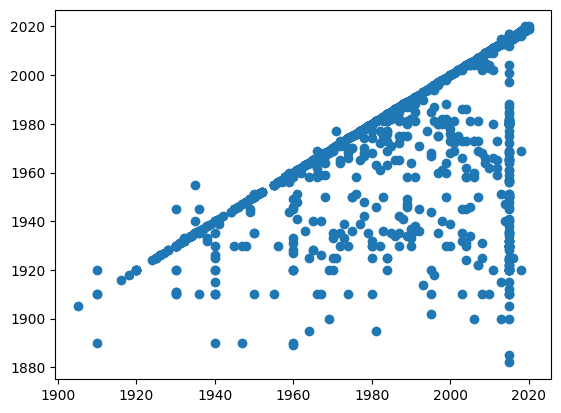

In [190]:
plt.scatter(df.Garagenbaujahr, df.Baujahr)
buf = df[(df.Garagenbaujahr != df.Baujahr) & (df.Garagenbaujahr != 2015)].shape[0] / df.shape[0] * 100
print('Count of different values in features Garagenbaujahr and Baujahr:', round(buf), '%')

In [216]:
# Save the dataset in csv file
df.to_csv('dataset/train_clean.csv')

### Correlations

<Axes: >

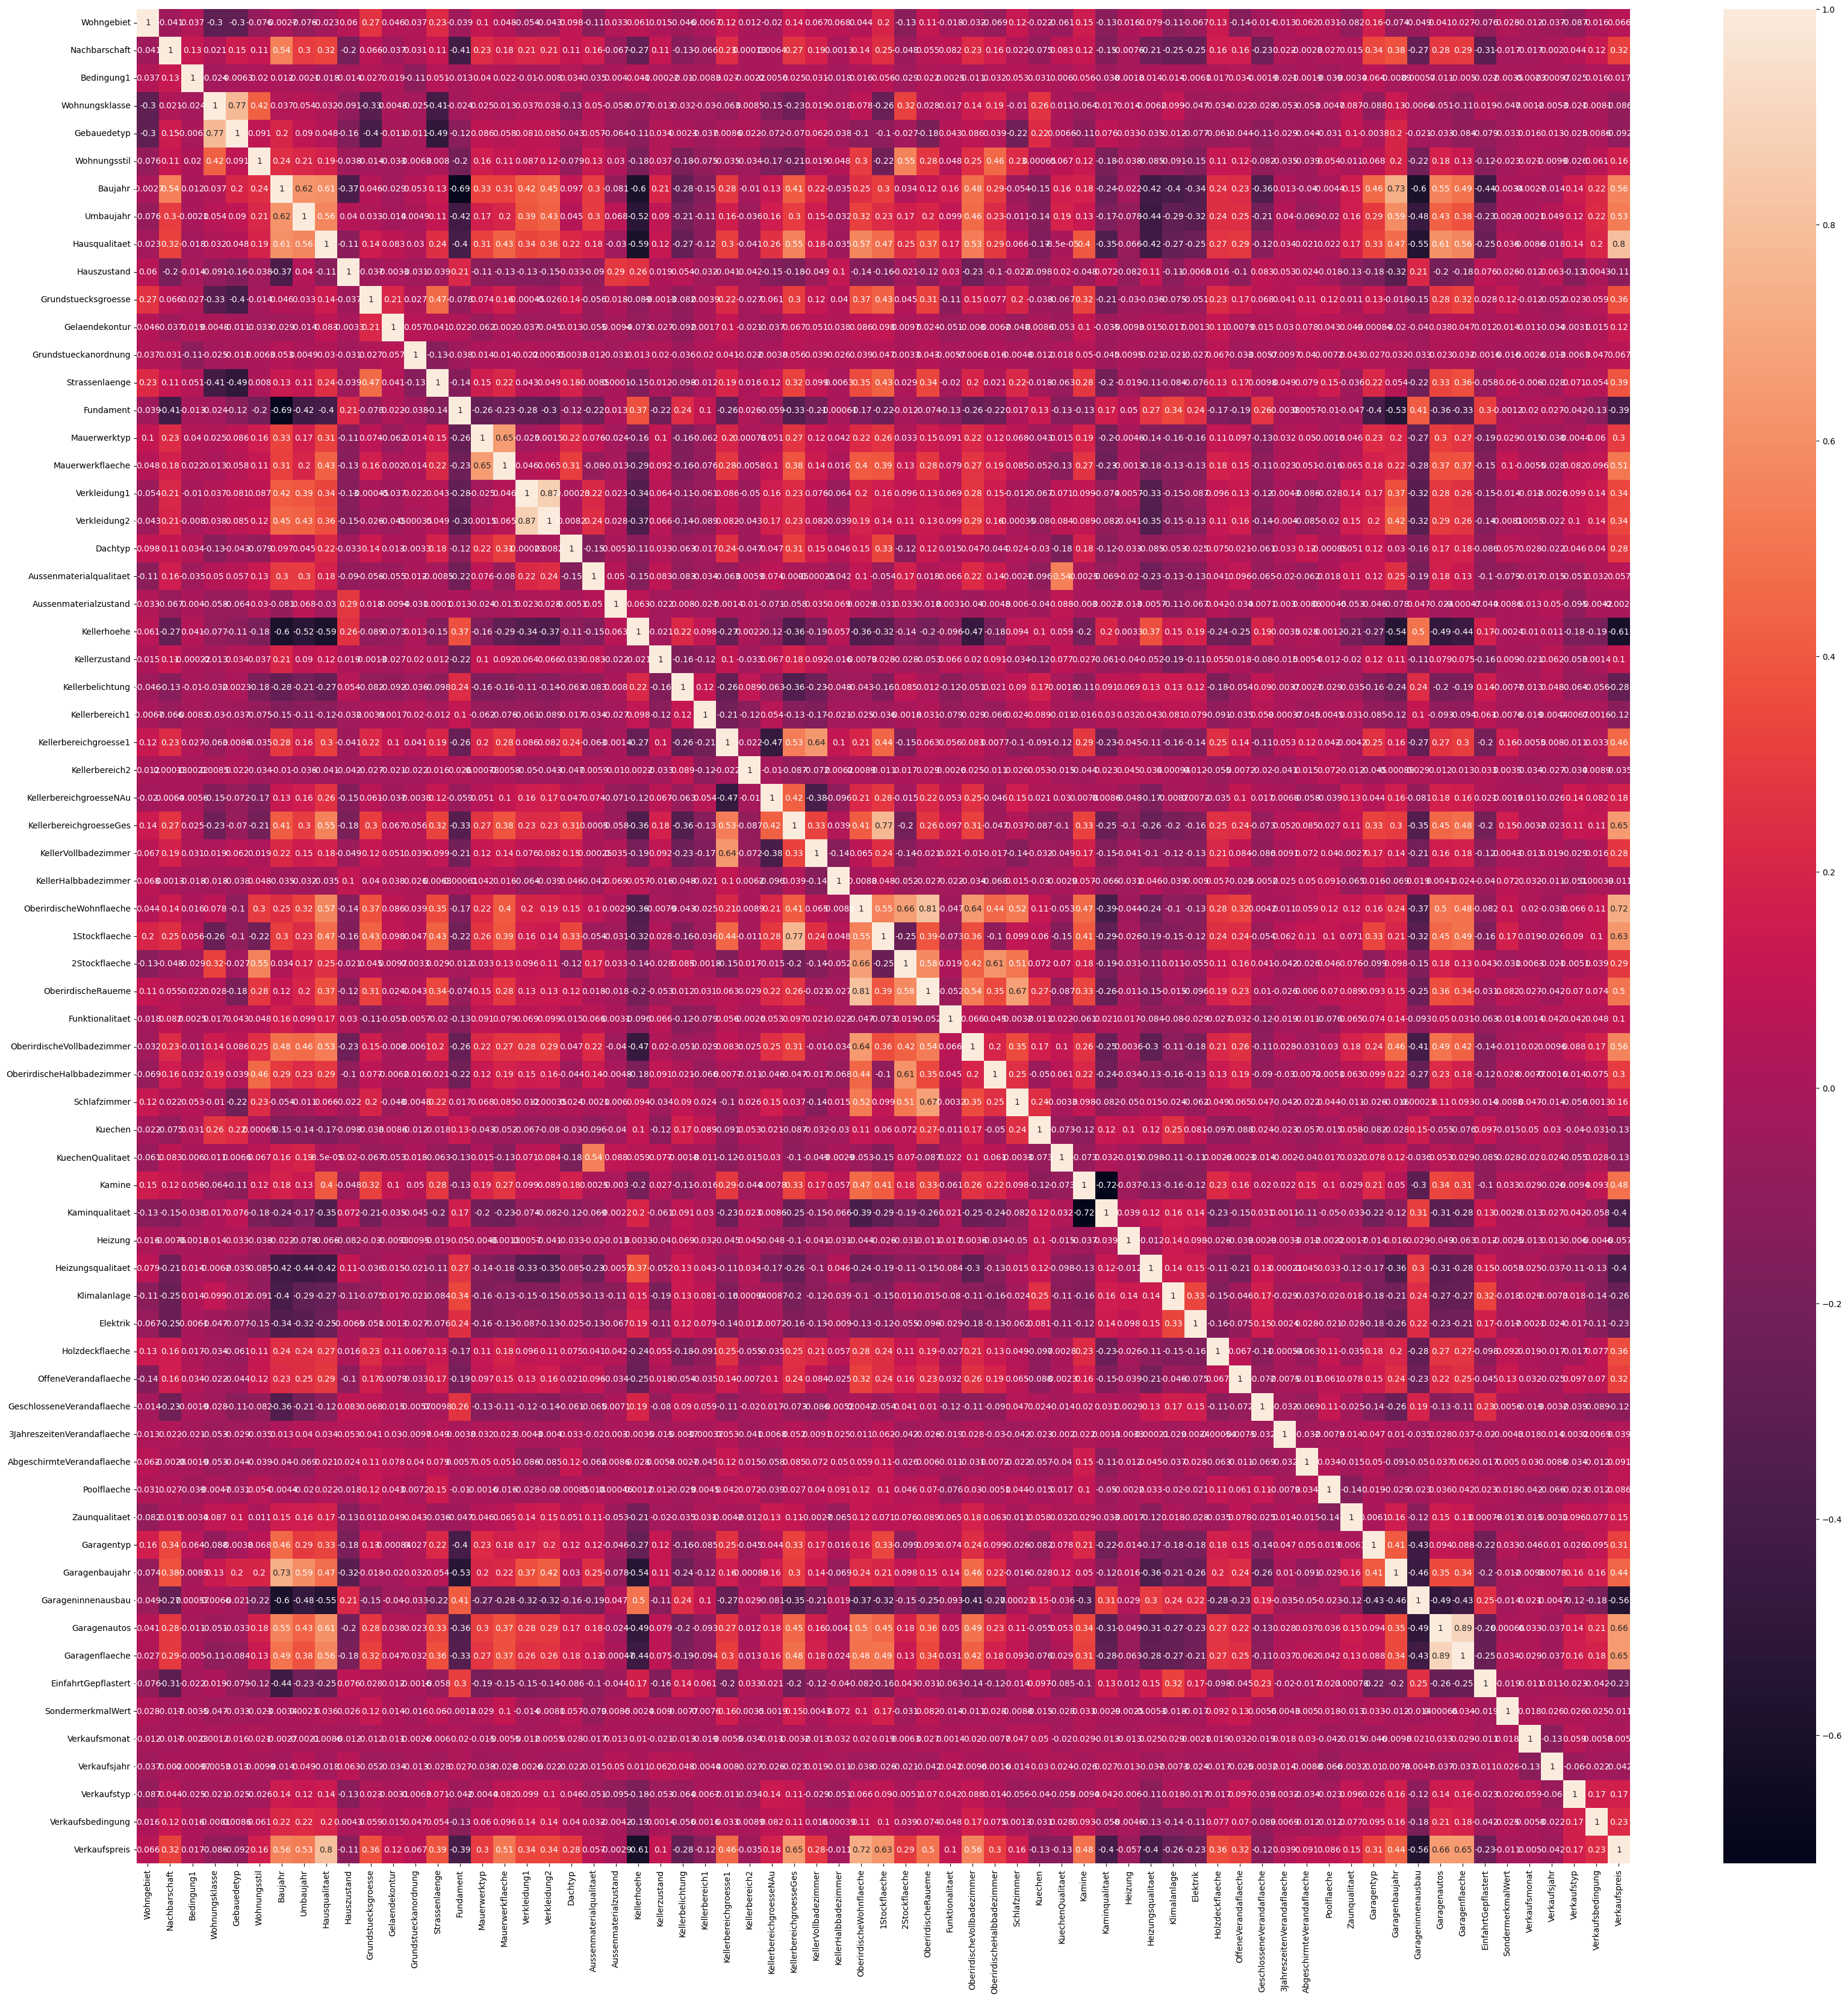

In [193]:
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder

buf = df.copy()

le = LabelEncoder()
numeric_columns = buf.describe().columns
categorical_columns = buf.columns.difference(numeric_columns)
for i in categorical_columns:
    buf[i] = le.fit_transform(buf[i])

plt.figure(figsize=(40,40))
sns.heatmap(buf.corr(), annot=True)

<Axes: >

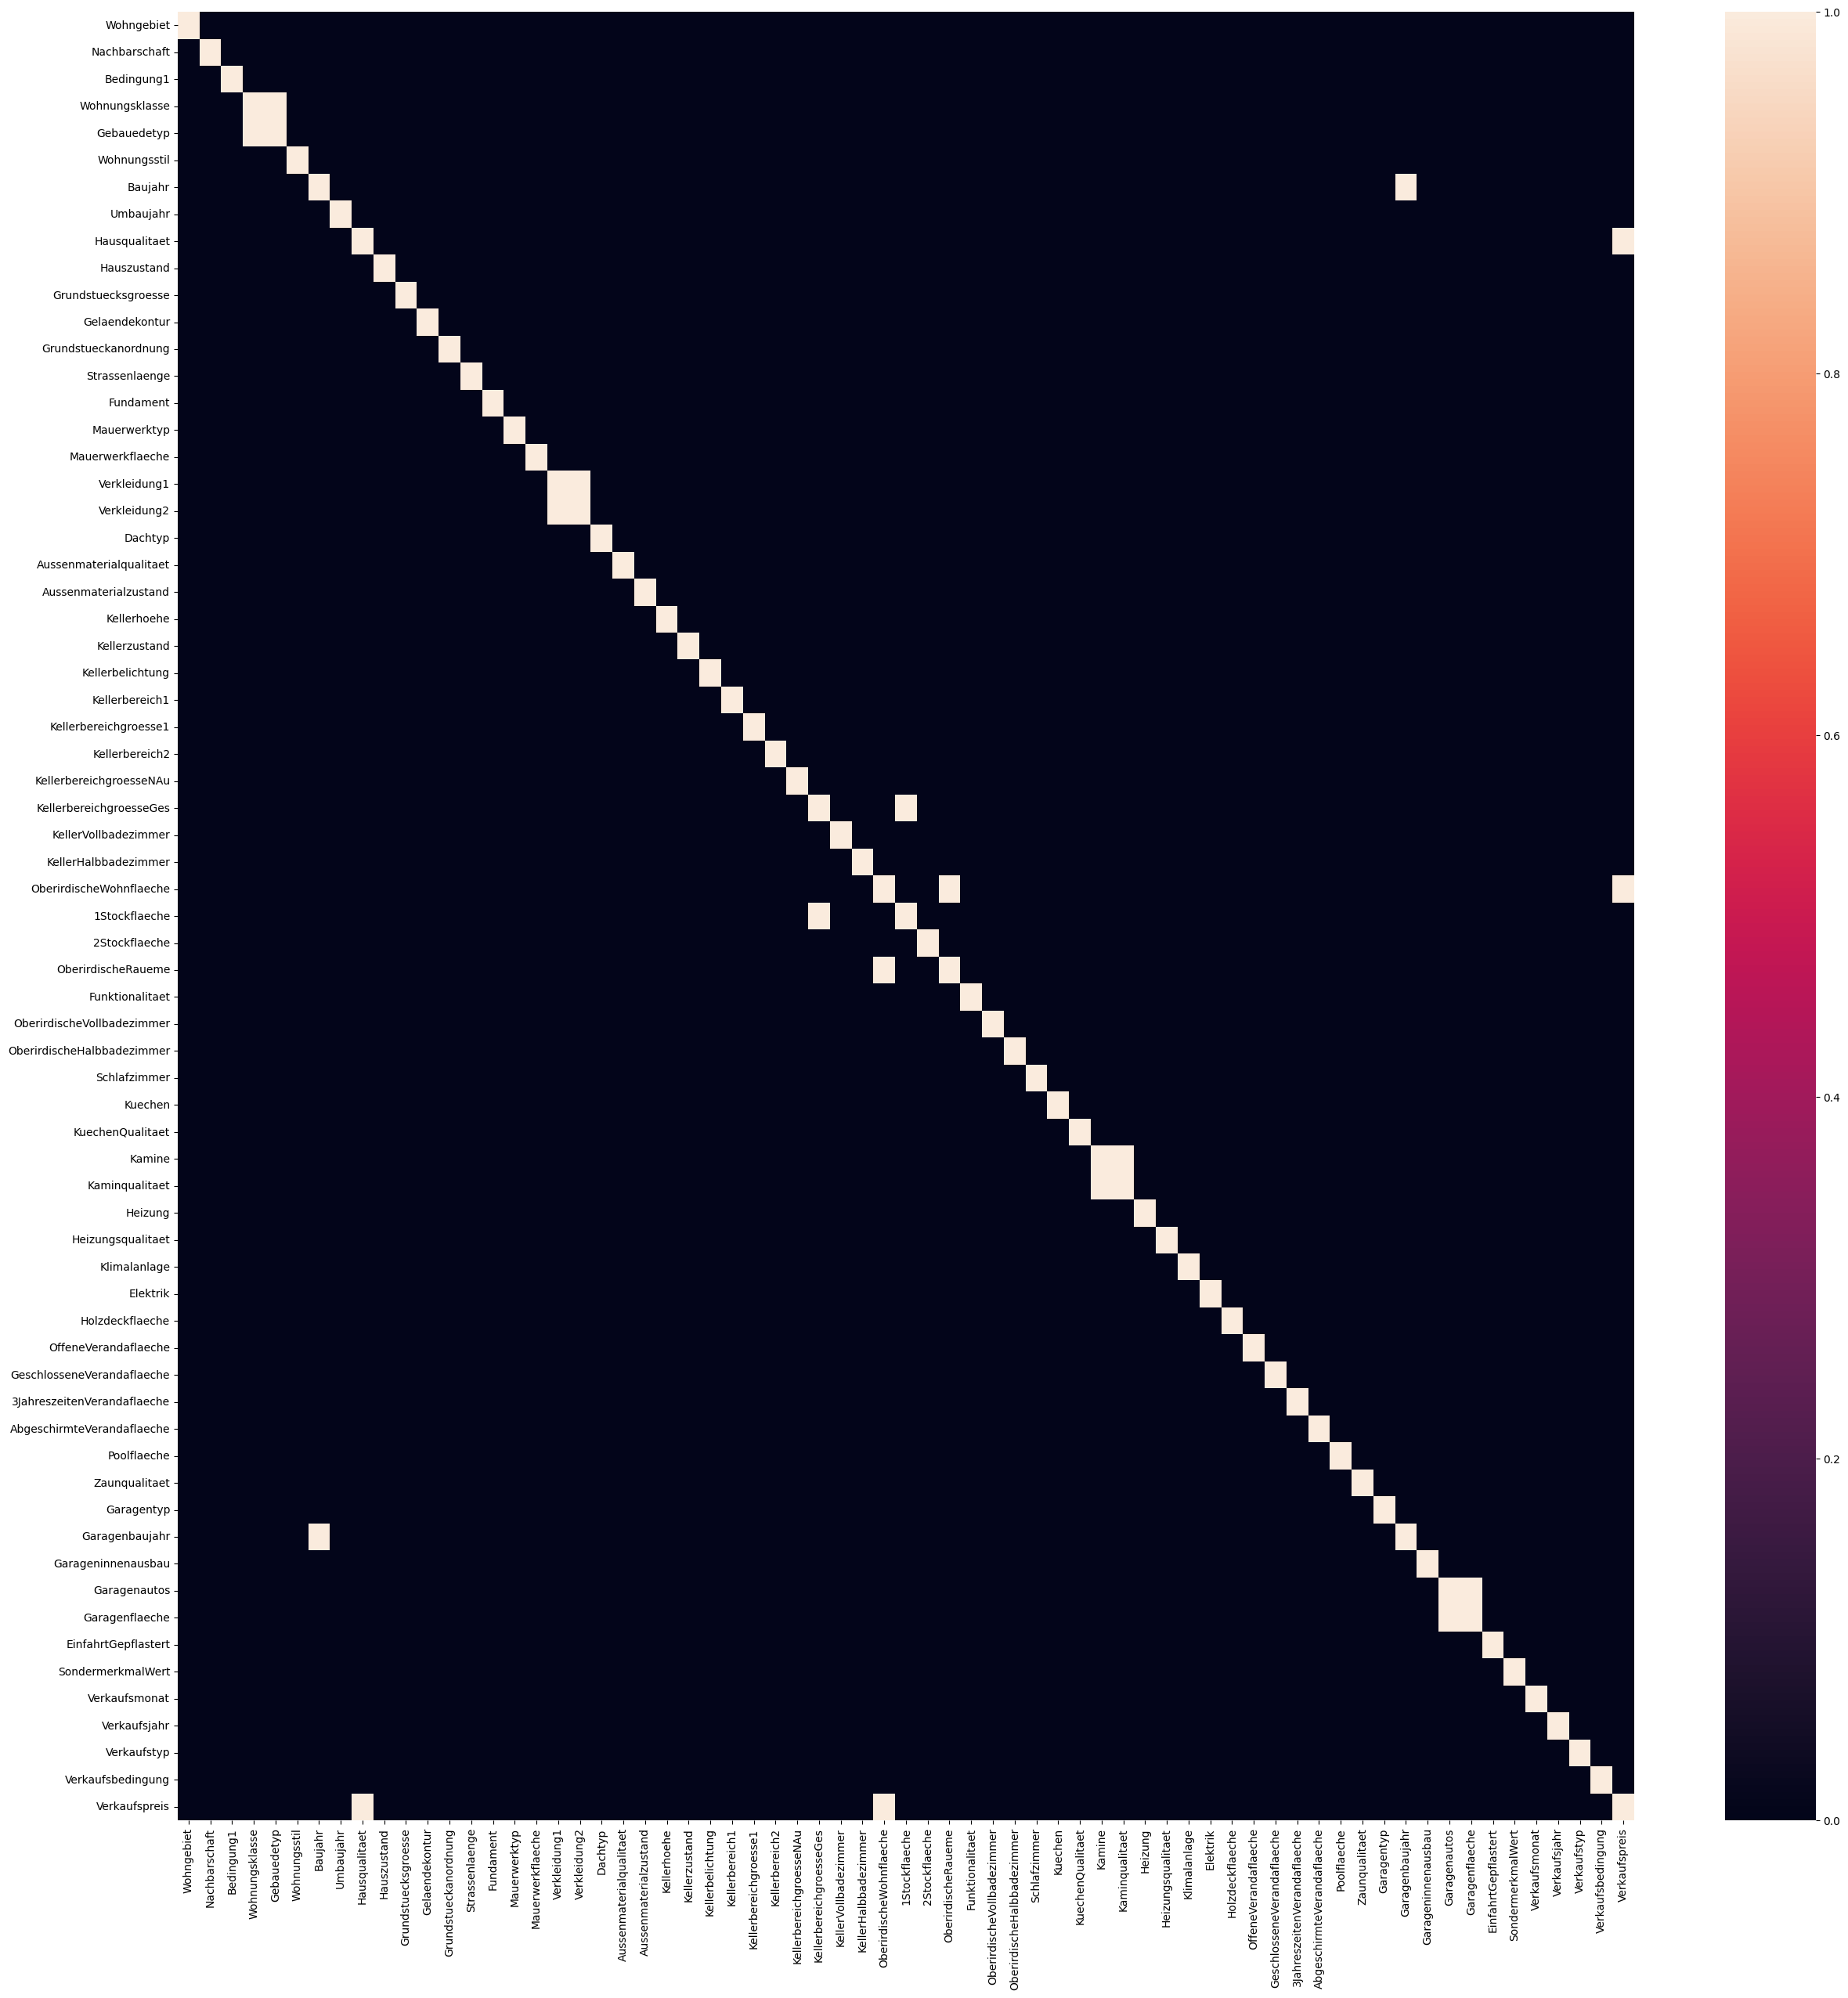

In [194]:
threshold = 0.7
buf = buf.corr()
plt.figure(figsize=(30,30))
sns.heatmap((buf > threshold) | (buf < -threshold))

It makes sence to make a PCA on:
- `Wohnungsklasse` and `Gebauedetyp` (or delete Gebauedetyp, because it has worse distribution)
- `Baujahr` and `Garagenbaujahr`
- `KellerbereichgroesseGes` and `1Stockflaeche` (and maybe make sence to merge all features which are connected to Flaeche and Zimmergroesse)
- `OberirdischeWohnflaeche` and `OberirdischeRaueme`
- `Kaminqualitaet` and `Kamine`
- `Garagenflaeche` and `Garagenautos`